VaR : Historical simulation v.s Monte Carlo simulation
===
分別利用歷史模擬法 (Historical simulation approach) 以及蒙地卡羅模擬法 (Monte Carlo simulation approach) 來計算 95% 風險值 (Value at Risk)。  
**計算參數：**  
資產：比特幣(BTC-USD)  
資產總值：1000萬  
資產投資期間：五天  
- - -
歷史模擬法 (Historical simulation approach)
---  

1.從 yahoo finance 直接抓取 BTC-USD 的每日資料(2022/03/21 ~ 2022/11/30)  

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

BTC_price = yf.download('BTC-USD', start = '2022-03-21', end = '2022-11-30')
print(BTC_price.head(5))
print(BTC_price.tail(5))

[*********************100%***********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2022-03-20  42191.406250  42241.164062  41004.757812  41247.824219   
2022-03-21  41246.132812  41454.410156  40668.042969  41077.996094   
2022-03-22  41074.105469  43124.707031  40948.281250  42358.808594   
2022-03-23  42364.378906  42893.507812  41877.507812  42892.957031   
2022-03-24  42886.652344  44131.855469  42726.164062  43960.933594   

               Adj Close       Volume  
Date                                   
2022-03-20  41247.824219  20127946682  
2022-03-21  41077.996094  24615543271  
2022-03-22  42358.808594  32004652376  
2022-03-23  42892.957031  25242943069  
2022-03-24  43960.933594  31042992291  
                    Open          High           Low         Close  \
Date                                                                 
2022-11-25  16602.26

2.進行資料清洗  

以每日收盤價進行計算，分別計算每日報酬率以及五日報酬率，再將所得五日報酬率進行排序，由小排到大。

In [9]:
#過去255天的收盤價
BTC_close = BTC_price[['Close']]
#計算報酬率 Ri = (Pi+1 - Pi)/Pi
BTC_close['Close_lag1'] = BTC_close['Close'].shift(1)
BTC_close['Close_lag5'] = BTC_close['Close'].shift(5)
BTC_close['Return1'] = round((BTC_close['Close'] - BTC_close['Close_lag1']) / BTC_close['Close_lag1'], 4)
BTC_close['Return5'] = round((BTC_close['Close'] - BTC_close['Close_lag5']) / BTC_close['Close_lag5'], 4)
#將報酬率由小到大排序
BTC_close_H = BTC_close.sort_values(by = 'Return5')
BTC_close1 = BTC_close_H.dropna()
print(BTC_close1.head(5))
print(BTC_close1.tail(5))

                   Close    Close_lag1    Close_lag5  Return1  Return5
Date                                                                  
2022-06-16  20381.650391  22572.839844  28360.810547  -0.0971  -0.2813
2022-06-14  22206.792969  22487.388672  30111.998047  -0.0125  -0.2625
2022-06-13  22487.388672  26762.648438  30214.355469  -0.1597  -0.2557
2022-11-09  15880.780273  18541.271484  21147.230469  -0.1435  -0.2490
2022-05-09  30296.953125  34059.265625  39698.371094  -0.1105  -0.2368
                   Close    Close_lag1    Close_lag5  Return1  Return5
Date                                                                  
2022-07-07  21637.587891  20548.246094  19242.255859   0.0530   0.1245
2022-07-08  21731.117188  21637.587891  19297.076172   0.0043   0.1261
2022-07-19  23389.433594  22485.689453  20569.919922   0.0402   0.1371
2022-09-11  21769.255859  21680.539062  18837.667969   0.0041   0.1556
2022-09-12  22370.449219  21769.255859  19290.324219   0.0276   0.1597


<ipython-input-9-f674e9546b0d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTC_close['Close_lag1'] = BTC_close['Close'].shift(1)
<ipython-input-9-f674e9546b0d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTC_close['Close_lag5'] = BTC_close['Close'].shift(5)
<ipython-input-9-f674e9546b0d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

3.計算出 95% 的臨界報酬率 (5%)

In [31]:
critical_value_H = np.percentile(BTC_close1['Return5'], 5)
print('critical_value_H  is ', critical_value_H)

critical_value_H  is  -0.15317499999999998


4.計算風險值(取整數)  

VaR = V * critical_value

In [30]:
V = 10000000
VaR_H = -V * critical_value_H
VaR_H = round(VaR_H)
print('VaR is ', VaR_H)

VaR is  1531750


- - -
蒙地卡羅模擬法 (Monte Carlo simulation approach)
---   
$$\frac{dS}{S} = \mu dt + \sigma dW_t$$  
1.計算蒙地卡羅模擬所需參數  

利用上一題取得的資料來計算模擬所需參數：  
$\mu$ ：日報酬平均值。  
$\sigma$ ：日報酬標準差。  
days ：模擬資料區間。  
z ：標準常態隨機取值。  
dt = 1。  
最終定義模擬日報酬函數。

In [23]:
mu = np.nanmean(BTC_close['Return1'])
sigma = np.nanstd(BTC_close['Return1'])
days = 255
z = np.random.normal(size = days)
dt = 1
daily_return = np.exp((mu - 0.5 * sigma**2) + sigma * z)

2.模擬蒙地卡羅路徑，並將路經圖繪製。(由 2022/11/30 為模擬起始點)

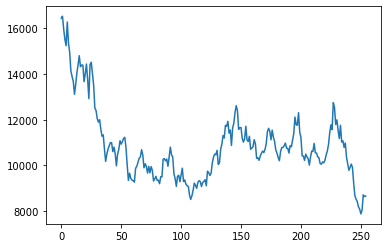

In [24]:
BTC_path = np.zeros_like(daily_return)
BTC_path[0] = BTC_price['Close'][-1]
for i in range(1, days):
    BTC_path[i] = BTC_path[i-1]*daily_return[i]
    
plt.plot(BTC_path)

3.以每日收盤價進行計算，計算五日報酬率，再將所得五日報酬率進行排序，由小排到大。

In [25]:
BTC_path = pd.DataFrame(BTC_path)
BTC_path.columns = ['Close']
BTC_path['Close_lag5'] = BTC_path['Close'].shift(5)
BTC_path['Return5'] = round((BTC_path['Close'] - BTC_path['Close_lag5']) / BTC_path['Close_lag5'], 4)
BTC_close_M = BTC_path.sort_values(by = 'Return5')
BTC_close2 = BTC_close_M.dropna()
print(BTC_close2.head(5))
print(BTC_close2.tail(5))

            Close    Close_lag5  Return5
248   8185.108977   9907.222020  -0.1738
30   12049.007254  14517.583810  -0.1700
203  10222.586069  12309.314348  -0.1695
247   8415.301487  10058.880583  -0.1634
10   13673.791463  16278.529000  -0.1600
            Close    Close_lag5  Return5
228  12541.056584  10918.608057   0.1486
195  12117.057305  10540.343752   0.1496
225  11775.337860  10223.775451   0.1518
137  11756.099243  10110.539729   0.1628
227  12749.033047  10627.997863   0.1996


4.計算出 95% 的臨界報酬率 (5%)

In [26]:
critical_value_M = np.percentile(BTC_close2['Return5'], 5)
print('critical_value_M  is ', critical_value_M)

critical_value_M  is  -0.138205


5.計算風險值(取整數)  

VaR = V * critical_value

In [29]:
VaR_M = -V * critical_value_M
VaR_M = round(VaR_M)
print('VaR is ', VaR_M)

VaR is  1382050
